# ANN assisted TPS on capped alanine dipeptide 1
In this notebook you will learn:
- how to setup an ANN assisted TPS simulation on a simple molecular system
- how to transform atomistic input coordinates to the descriptor space in which the ANN learns

This notebook assumes some familiarity with `openpathsampling` and `aimmd`, please do the Toy notebooks first.

In [1]:
# to be able tu run multiple notebooks in paralell:
# tell tf to not grab the whole GPU memory available
import tensorflow as tf
if tf.version.VERSION.startswith('2.'):
    # tell tf to use only the GPU mem it needs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print('available GPUs: ', gpus)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    from tensorflow.keras import backend as K

else:
    conf = tf.compat.v1.ConfigProto()
    conf.gpu_options.allow_growth = True
    conf.gpu_options.per_process_gpu_memory_fraction = 0.25
    #tf.enable_eager_execution(config=conf)\n",
    sess = tf.compat.v1.Session(config=conf)
    from tensorflow.keras import backend as K
    K.set_session(sess)

available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
%matplotlib inline

In [3]:
import os
import aimmd
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 9, 6  # make the figures a bit bigger
import openpathsampling as paths
import openpathsampling.engines.openmm as peng_omm
import simtk.openmm as mm
import simtk.unit as unit
from simtk.openmm import app
from openmmtools.integrators import VVVRIntegrator

In [4]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [5]:
# name our logfiles
LOGCONFIG['handlers']['stdf']['filename'] = 'ala_keras_simulation.log'
LOGCONFIG['handlers']['initf']['filename'] = 'ala_keras_init.log'

In [6]:
cur_dir = os.path.abspath(os.getcwd())  # needed to find our initial TP later
# change to the working directory of choice
wdir = '/home/tb/hejung/DATA/aimmd_scratch/SimData_keras_ala/'
#wdir = None
if wdir is not None:
    if not os.path.isdir(wdir):
        os.mkdir(wdir)
    os.chdir(wdir)

# setup logging in that directory
import logging.config
logging.config.dictConfig(LOGCONFIG)

### initial TP and states
Generating the initial TP is out of scope of this tutorial, please consult the `openpathsampling` examples for that.

In [7]:
# load initial TP for ala (generated at high temp, 400K)
# we load the h5py trajectory and define the states from scratch
# for better machine interoperability and smaller footprint in repo
initialTP_md = md.load(os.path.join(cur_dir, 'ala_400K_TP_low_barrier.h5'))
initialTP = peng_omm.trajectory_from_mdtraj(initialTP_md)
template = peng_omm.snapshot_from_pdb(os.path.join(cur_dir, "AD_initial_frame.pdb"))

# define the CVs
psi = paths.MDTrajFunctionCV("psi", md.compute_dihedrals, template.topology, indices=[[6,8,14,16]])
phi = paths.MDTrajFunctionCV("phi", md.compute_dihedrals, template.topology, indices=[[4,6,8,14]])

# define the states
deg = 180.0/np.pi
C_7eq = (paths.PeriodicCVDefinedVolume(phi, lambda_min=-180/deg, lambda_max=0/deg,
                                     period_min=-np.pi, period_max=np.pi) &
         paths.PeriodicCVDefinedVolume(psi, lambda_min=120/deg, lambda_max=200/deg,
                                     period_min=-np.pi, period_max=np.pi)
        ).named("C_7eq")

alpha_R = (paths.PeriodicCVDefinedVolume(phi, -180/deg, 0/deg, -np.pi, np.pi) &
           paths.PeriodicCVDefinedVolume(psi, -50/deg, 30/deg, -np.pi, np.pi)).named("alpha_R")

### engine setup

In [8]:
forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')
pdb = app.PDBFile(os.path.join(cur_dir, "AD_initial_frame.pdb"))
system = forcefield.createSystem(pdb.topology,
                                 nonbondedMethod=app.PME,
                                 nonbondedCutoff=1.0*unit.nanometers,
                                 constraints=app.HBonds,
                                 rigidWater=True,
                                 ewaldErrorTolerance=0.0005
                                 )
integrator = VVVRIntegrator(300*unit.kelvin,  # T
                            1.0/unit.picoseconds,  # fric
                            2.0*unit.femtoseconds)  # dt
integrator.setConstraintTolerance(0.00001)
engine_options = {
    'n_frames_max': 20000,
    'nsteps_per_frame': 10,
}
engine = peng_omm.Engine(template.topology,
                         system,
                         integrator,
                         options=engine_options
                         )
engine.name = '300K'

### Transforming atomistic coordinates to training descriptors: Symmetry functions and internal coordinates

In [9]:
# The slow part: symmetry functions

# symmerty functions first
cutoff = 0.6 # consider G5 worst case scenarios for cutoff!
# g2_parms are expected to be a list of lists, each sublist needs to contain [eta, r_s] 
g2_parms = [[200., 0.1], [200., 0.25], [200., 0.4]]#, [200., 0.55], [200., 0.7], [200., 0.85]]

# g5_parms are also expected to be a list of lists, here each sublist needs to contain
# [eta, r_s, zeta, lambda]
# here we just create the list of [eta, r_s] for G5,
# we add the missing parmeters below since:
# we use the same zetas, which influence the sharpness of the angular peaks, for all G5s at different probing radii
# and we use the same two lambda values [-1, +1], which influence the location of the maximum, i.e. at angle=0 or at angle=\pi
g5_etas_rs = [[120., 0.1],
              [120., 0.25],
              [120., 0.4],
              #[120., 0.55],
              #[120., 0.7],
              #[120., 0.85]
             ]
# all zetas for all G5, high zeta means sharp angular resultion
# Note: zeta must be an even number, using these powers of 2 empirically works well
zetas = [
        1,
        2,
        4,
        16,
        64,
        ]
# construct g5_parms from previously defined values
# combine every eta, r_s with all zetas and both possible lambda values
g5_parms = [[eta, r_s, zeta, lamb] for (eta, r_s) in g5_etas_rs for zeta in zetas for lamb in [+1., -1.]]

# combine G2 and G5 params into one list to pass to the SF transformation function
g_parms = [g2_parms, g5_parms]

mol_idxs, solv_idxs = aimmd.coords.symmetry.generate_indices(template.topology.mdtraj,
                                                            ['HOH'],
                                                            solvent_atelements=[['O', 'H']],
                                                            reactant_selection='not resname HOH')

sf_parms = {'mol_idxs': mol_idxs, 'solv_idxs': solv_idxs, 'g_parms': g_parms,
            'cutoff': cutoff, 'n_per_solv': [[1., 2.]], 'rho_solv': [33.]}

sf_transform = paths.MDTrajFunctionCV('sf_transform', aimmd.coords.symmetry.transform,  # transform is an alias for sf
                                      template.topology, **sf_parms)

In [10]:
# The fast part: internal coordinates

pairs, triples, quadruples = aimmd.coords.internal.generate_indices(template.topology.mdtraj, source_idx=0)

ic_parms = {'pairs': pairs, 'triples': triples, 'quadruples': quadruples}

ic_transform = paths.MDTrajFunctionCV('ic_transform', aimmd.coords.internal.transform,  # transform is an alias for ic
                                      template.topology, **ic_parms)

In [11]:
# set this to True to do the full setup with symmetry functions, will be much slower
# leave it at False and we will not calculate any symmetry functions and train on internal coords only
# setting this to True will increase runtime by a factor of approximately 10 (depending on the choice of symmetry function cutoff)
we_have_time = True

if we_have_time:
    # create this little helper function to concatenate the descriptors we are interested in
    def transform_func(mdtra, sf_parms, ic_parms):
        import mdtraj as md
        from aimmd.coords.symmetry import sf
        from aimmd.coords.internal import ic
        import numpy as np
        return np.concatenate([ic(mdtra, **ic_parms),
                               sf(mdtra, **sf_parms),
                               ],
                              axis=1)

    descriptor_transform = paths.MDTrajFunctionCV('descriptor_transform', transform_func,
                                                  template.topology,
                                                  sf_parms=sf_parms, 
                                                  ic_parms=ic_parms,
                                                  cv_scalarize_numpy_singletons=False)
else:
    # create this little helper function to concatenate the descriptors we are interested in
    def transform_func(mdtra, ic_parms):
        import mdtraj as md
        from aimmd.coords.internal import ic
        import numpy as np
        return ic(mdtra, **ic_parms)

    descriptor_transform = paths.MDTrajFunctionCV('descriptor_transform', transform_func,
                                                  template.topology,
                                                  ic_parms=ic_parms,
                                                  cv_scalarize_numpy_singletons=False)

number of input descriptors:  1507


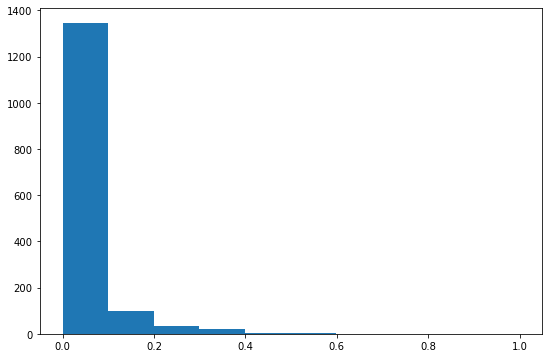

In [12]:
# lets have a look a the transformed coordinate values
# they should be all approximately in [0, 1]
trans_coords = descriptor_transform(template)
# also set cv_ndim, because this will be the number of network inputs
cv_ndim = trans_coords.shape[0]
plt.hist(trans_coords);
print('number of input descriptors: ', cv_ndim)

### aimmd setup: create an ANN, RCModel, etc

In [13]:
from tensorflow.keras import optimizers, regularizers

In [14]:
# use an aimmd utility function to create a pyramidal arch with a ResNet top part
# you could however wrap any keras model that has been compiled with an optimizer in an aimmd RCModel in the next cell
n_lay_pyramid = 4
n_unit_top = 10
n_lay_top = 2
n_unit_base = descriptor_transform(template).shape[0]
print('number of input descriptors: ', n_unit_base)

fact = (n_unit_top / n_unit_base)**(1./(n_lay_pyramid-1))

hidden_parms = []
for i in range(n_lay_pyramid):
    hidden_parms += [{'units': max(n_unit_top, int(n_unit_base * fact**i)),
                     'activation': 'selu', # elu; selu is good!
                     'use_bias': True,
                     'kernel_initializer': 'lecun_normal',
                     'bias_initializer': 'lecun_normal',
                     'kernel_regularizer': None,#regularizers.l1(l=0.0001),
                     'bias_regularizer': None,
                     'activity_regularizer': None,
                     'kernel_constraint': None,
                     'bias_constraint': None,
                     'dropout': 0.15 * fact**i,
                     }
                    ]
for i in range(n_lay_top):
    
    hidden_parms += [{'units': n_unit_top,
                     'activation': 'elu',
                     'use_bias': True,
                     'kernel_initializer': 'lecun_normal',
                     'bias_initializer': 'lecun_normal',
                     'kernel_regularizer': None,# regularizers.l1(l=0.0001),
                     'bias_regularizer': None,
                     'activity_regularizer': None,
                     'kernel_constraint': None,
                     'bias_constraint': None,
                     'dropout': None,
                     'residual_n_skip': 4,
                     }
                    ]
    

optimizer = optimizers.Adam(lr=0.001) 
# create a ResNet with binomial loss to predict p_B
resnet = aimmd.keras.create_resnet(ndim=n_unit_base, hidden_parms=hidden_parms,
                                  optimizer=optimizer,
                                  n_states=2,  # does not really matter if multi_state=False
                                  multi_state=False)

number of input descriptors:  1507


In [15]:
aimmd_store = aimmd.Storage(os.path.join(wdir, 'aimmd_storage.h5'), mode='w')

In [16]:
# we take an ExpectedEfficiencyPytorchRCModel,
# this RCmodel scales the learning rate by the expected efficiency factor (1 - n_TP_true / n_TP_expected)**2
model = aimmd.keras.EEScaleKerasRCModel(nnet=resnet,
                                        states=[C_7eq, alpha_R],
                                        descriptor_transform=descriptor_transform,
                                        ee_params={'lr_0': 0.001,
                                                   'lr_min': 0.00005,  # lr_min = lr_0 / 20 is a good choice empirically
                                                   'epochs_per_train': 4,
                                                   'interval': 5,
                                                   'window': 75,
                                                   },
                                        cache_file=aimmd_store,
                                       )

In [17]:
trainset = aimmd.TrainSet(n_states=2)

In [18]:
trainhook = aimmd.ops.TrainingHook(model, trainset)
storehook = aimmd.ops.AimmdStorageHook(aimmd_store, model, trainset)
densityhook = aimmd.ops.DensityCollectionHook(model)

In [19]:
selector = aimmd.ops.RCModelSelector(model=model,
                                    states=[C_7eq, alpha_R],
                                    distribution='lorentzian',
                                    scale=1.0,
                                    )

### OPS setup: TPS strategy and sampled transitions

In [20]:
network = paths.TPSNetwork.from_states_all_to_all([C_7eq, alpha_R])
move_scheme = paths.MoveScheme(network=network)
beta = 1.0 / (engine.integrator.getTemperature() * unit.BOLTZMANN_CONSTANT_kB)
modifier = paths.RandomVelocities(beta=beta, engine=engine)
tw_strategy = paths.strategies.TwoWayShootingStrategy(modifier=modifier,
                                                      selector=selector,
                                                      engine=engine,
                                                      group='TwoWayShooting')
move_scheme.append(tw_strategy)
move_scheme.append(paths.strategies.OrganizeByMoveGroupStrategy())
move_scheme.build_move_decision_tree()

In [21]:
initial_conditions = move_scheme.initial_conditions_from_trajectories(initialTP)

No missing ensembles.
No extra ensembles.


In [22]:
storage = paths.Storage('ala_LB_keras_ResNet.nc', mode='w', template=template)

sampler = paths.PathSampling(storage=storage,
                             sample_set=initial_conditions,
                             move_scheme=move_scheme)

In [23]:
sampler.attach_hook(trainhook)
sampler.attach_hook(storehook)
sampler.attach_hook(densityhook)

In [24]:
sampler.run(2000)

Working on Monte Carlo cycle number 2000
Running for 2 hours 1 minute 30 seconds -  3.65 seconds per step
Estimated time remaining: 3 seconds
DONE! Completed 2000 Monte Carlo cycles.


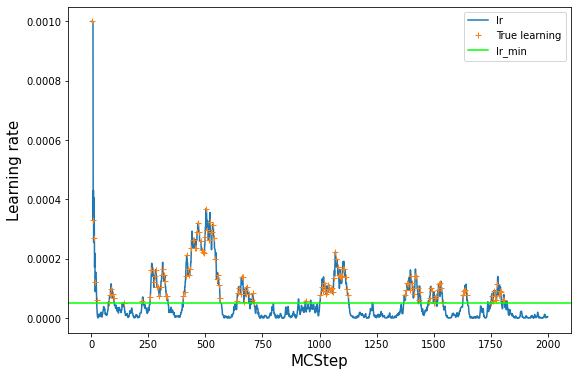

In [25]:
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

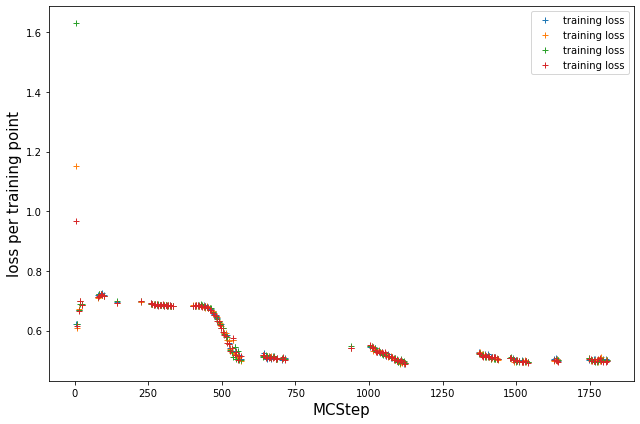

In [26]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

In [27]:
# get the number of accepts from OPS storage
accepts = []
for step in storage.steps:
    if step.change.canonical.accepted:
        accepts.append(1.)
    else:
        accepts.append(0.)

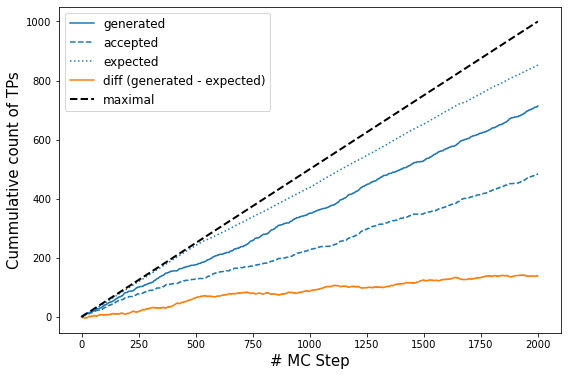

In [28]:
p_ex = np.array(model.expected_p)

l, = plt.plot(np.cumsum(trainset.transitions), label='generated');
plt.plot(np.cumsum(accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff (generated - expected)')
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=12);
plt.ylabel('Cummulative count of TPs', size=15)
plt.xlabel('# MC Step', size=15);

# HIPR

In [29]:
hipr = aimmd.analysis.HIPRanalysis(model, trainset)

In [30]:
hipr_plus_losses, hipr_plus_stds = hipr.do_hipr_plus(25)

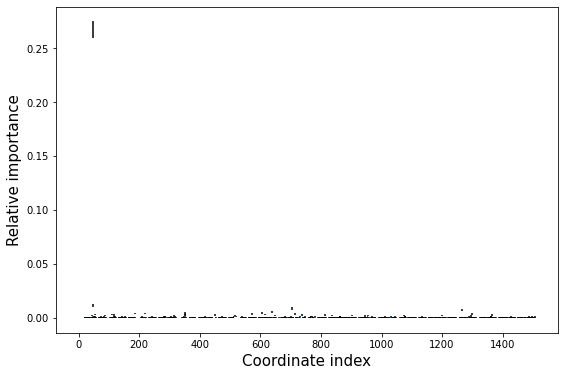

In [31]:
loss_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]  # hipr_losses[-1] is the reference loss over the unaltered trainset

plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_plus_stds[:-1])
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

In [34]:
ic_parms["quadrouples"] = ic_parms["quadruples"]

In [37]:
# what are the most important contributors?
max_idxs = np.argsort(loss_diffs)[::-1]
sf_parms = descriptor_transform.kwargs['sf_parms']
ic_parms = descriptor_transform.kwargs['ic_parms']

print('reference loss:', hipr_plus_losses[-1])
for idx in max_idxs[:40]:
    print()
    print('loss for idx {:d}: '.format(idx), hipr_plus_losses[idx])
    print(aimmd.coords.get_involved(idx, sf_parms=sf_parms, ic_parms=ic_parms, solvent_atoms=[['O', 'H']], solvent_resname=['HOH']))

reference loss: 0.4989878237247467

loss for idx 48:  0.7660467290878296
('IC', ('cos', [6, 8, 14, 15]))

loss for idx 47:  0.5100106143951416
('IC', ('sin', [6, 8, 14, 15]))

loss for idx 704:  0.5074009466171264
('SF', ('G5', [120.0, 0.25, 64, -1.0], 19, 'HOH', 'O'))

loss for idx 1265:  0.5063236474990844
('SF', ('G5', [120.0, 0.25, 64, -1.0], 14, 'HOH', 'H'))

loss for idx 638:  0.5038898038864136
('SF', ('G5', [120.0, 0.25, 64, -1.0], 17, 'HOH', 'O'))

loss for idx 605:  0.5034584665298462
('SF', ('G5', [120.0, 0.25, 64, -1.0], 16, 'HOH', 'O'))

loss for idx 353:  0.5028022313117981
('SF', ('G2', [200.0, 0.25], 9, 'HOH', 'O'))

loss for idx 219:  0.5027276182174683
('SF', ('G5', [120.0, 0.4, 64, -1.0], 4, 'HOH', 'O'))

loss for idx 186:  0.5026985812187195
('SF', ('G5', [120.0, 0.4, 64, -1.0], 3, 'HOH', 'O'))

loss for idx 714:  0.5025678777694702
('SF', ('G5', [120.0, 0.4, 64, -1.0], 19, 'HOH', 'O'))

loss for idx 572:  0.5024674677848816
('SF', ('G5', [120.0, 0.25, 64, -1.0], 15

In [39]:
storage.sync_all()
storage.close()

In [40]:
aimmd_store.close()